# **Simple example - TSP**

Approximation of the TSP by Simulated Annealing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
import time
import random
import math
from tqdm import tqdm

# Data

#### Open the data

In [ ]:
tsp_data_filepath = "/content/drive/MyDrive/Colab Notebooks/optimisation/tsp_data/berlin52.tsp"

In [ ]:
def read_tsp_data(filepath):
    """
    Reads a TSP file and returns a list of coordinates.

    Args:
    filepath (str): The path to the TSP file.

    Returns:
    list of tuples: A list where each tuple contains the coordinates of a city.
    """
    # Initialize an empty list to store the coordinates
    coordinates = []

    # Flag to indicate whether we are in the node coordinates section
    node_coord_section = False

    # Open the file and read line by line
    with open(filepath, 'r') as file:
        for line in file:
            # Check if we have reached the 'NODE_COORD_SECTION'
            if line.strip() == 'NODE_COORD_SECTION':
                node_coord_section = True
                continue
            # Check if we have reached the end of the file
            elif line.strip() == 'EOF':
                break
            # If we are in the node coordinates section, process the line
            elif node_coord_section:
                parts = line.split()
                # Append the coordinates to the list, converting them to floats
                coordinates.append((int(parts[0]),float(parts[1]), float(parts[2])))

    return coordinates

In [ ]:
tsp_cities = read_tsp_data(tsp_data_filepath)[:6]
tsp_cities

[(1, 565.0, 575.0),
 (2, 25.0, 185.0),
 (3, 345.0, 750.0),
 (4, 945.0, 685.0),
 (5, 845.0, 655.0),
 (6, 880.0, 660.0)]

# Simulated Annealing Implementation

#### Initialize solution

In [ ]:
# Generate a random solution (starting point)
def initial_solution(tsp_cities):
    # Start with the first element
    start = tsp_cities[0]
    # Exclude the first element when shuffling the rest of the data
    rest_of_cities = tsp_cities[1:]
    random.shuffle(rest_of_cities)
    # Return the individual starting and ending with the first element
    individual = [start] + rest_of_cities + [start]
    return individual

sol = initial_solution(tsp_cities)
sol

[(1, 565.0, 575.0),
 (3, 345.0, 750.0),
 (6, 880.0, 660.0),
 (4, 945.0, 685.0),
 (5, 845.0, 655.0),
 (2, 25.0, 185.0),
 (1, 565.0, 575.0)]

#### Cost function

In [ ]:
# Compute the distance
def compute_distance(a, b):
    _, x1, y1 = a
    _, x2, y2 = b
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

# Create a distance matrix for all cities
def create_distance_matrix(tsp_cities):
    num_cities = len(tsp_cities)
    distance_matrix = np.zeros((num_cities, num_cities))

    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            distance = compute_distance(tsp_cities[i], tsp_cities[j])
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance  # Mirror the distance as the matrix is symmetric

    return distance_matrix

distance_matrix = create_distance_matrix(tsp_cities)
print(distance_matrix.shape)
distance_matrix

(6, 6)


array([[   0.        ,  666.10809934,  281.11385594,  395.6008089 ,
         291.20439557,  326.26676202],
       [ 666.10809934,    0.        ,  649.32657423, 1047.09120902,
         945.14549145,  978.08486339],
       [ 281.11385594,  649.32657423,    0.        ,  603.51056329,
         508.9449872 ,  542.51728083],
       [ 395.6008089 , 1047.09120902,  603.51056329,    0.        ,
         104.40306509,   69.64194139],
       [ 291.20439557,  945.14549145,  508.9449872 ,  104.40306509,
           0.        ,   35.35533906],
       [ 326.26676202,  978.08486339,  542.51728083,   69.64194139,
          35.35533906,    0.        ]])

In [ ]:
# Compute the sum of the distances between cities / the longer of the path
def fitness(solution, distance_matrix):
    total_distance = 0
    num_cities = len(solution)

    for i in range(num_cities - 1):
        city_from = solution[i][0]
        city_to = solution[i + 1][0]
        total_distance += distance_matrix[city_from-1][city_to-1]

    return total_distance


print('solution:', sol)
print('distance:', fitness(sol, distance_matrix))

solution: [(1, 565.0, 575.0), (3, 345.0, 750.0), (6, 880.0, 660.0), (4, 945.0, 685.0), (5, 845.0, 655.0), (2, 25.0, 185.0), (1, 565.0, 575.0)]
distance: 2608.9297340240614


#### Neighbourhood operators

In [ ]:
# Swap Operator: This operator exchanges the positions of two cities in a route.
def swap_operator(solution):
    new_solution = solution.copy()
    # Randomly select two indexes, avoiding the first and last elements
    idx1, idx2 = np.random.choice(range(1, len(new_solution) - 1), 2, replace=False)
    # Perform the swap
    new_solution[idx1], new_solution[idx2] = new_solution[idx2], new_solution[idx1]
    return new_solution

print('solution:', sol)
print('swap_operator:', swap_operator(sol))

solution: [(1, 565.0, 575.0), (3, 345.0, 750.0), (6, 880.0, 660.0), (4, 945.0, 685.0), (5, 845.0, 655.0), (2, 25.0, 185.0), (1, 565.0, 575.0)]
swap_operator: [(1, 565.0, 575.0), (5, 845.0, 655.0), (6, 880.0, 660.0), (4, 945.0, 685.0), (3, 345.0, 750.0), (2, 25.0, 185.0), (1, 565.0, 575.0)]


In [ ]:
# Insert Operator: This operator moves a city from one random position to another.
def insert_operator(solution):
    new_solution = solution.copy()
    # Randomly select two indexes, avoiding the first and last elements
    idx1, idx2 = np.random.choice(range(1, len(new_solution) - 1), 2, replace=False)
    # Perform the insert operation
    city_to_move = new_solution.pop(idx1)
    new_solution.insert(idx2, city_to_move)
    return new_solution

print('solution:', sol)
print('insert_operator:', insert_operator(sol))

solution: [(1, 565.0, 575.0), (3, 345.0, 750.0), (6, 880.0, 660.0), (4, 945.0, 685.0), (5, 845.0, 655.0), (2, 25.0, 185.0), (1, 565.0, 575.0)]
insert_operator: [(1, 565.0, 575.0), (3, 345.0, 750.0), (4, 945.0, 685.0), (6, 880.0, 660.0), (5, 845.0, 655.0), (2, 25.0, 185.0), (1, 565.0, 575.0)]


In [ ]:
# Inverse Subroutes Operator: This operator reverses the order of the routes between two randomly selected nodes.
def inverse_subroutes_operator(solution):
    new_solution = solution.copy()
    # Select two random indexes and sort them
    idx1, idx2 = sorted(np.random.choice(range(1, len(new_solution) - 1), 2, replace=False))
    # Perform the inverse operation
    new_solution[idx1:idx2+1] = reversed(new_solution[idx1:idx2+1])
    return new_solution

print('solution:', sol)
print('inverse_subroutes_operator:', inverse_subroutes_operator(sol))

solution: [(1, 565.0, 575.0), (3, 345.0, 750.0), (6, 880.0, 660.0), (4, 945.0, 685.0), (5, 845.0, 655.0), (2, 25.0, 185.0), (1, 565.0, 575.0)]
inverse_subroutes_operator: [(1, 565.0, 575.0), (4, 945.0, 685.0), (6, 880.0, 660.0), (3, 345.0, 750.0), (5, 845.0, 655.0), (2, 25.0, 185.0), (1, 565.0, 575.0)]


In [ ]:
# Insert Subroutes Operator: This operator selects a range of cities and inserts them at a random position.
def insert_subroutes_operator(solution):
    # Ensure there are enough cities for the operation
    if len(solution) <= 3:
        return solution

    new_solution = solution.copy()
    # Select two random indexes and sort them
    idx1, idx2 = sorted(np.random.choice(range(1, len(new_solution) - 1), 2, replace=False))
    # Extract the subroute
    subroute = new_solution[idx1:idx2+1]
    # Remove the subroute from the original position
    new_solution = new_solution[:idx1] + new_solution[idx2+1:]

    # Insert the subroute at a new position
    if len(new_solution) > len(subroute):
        insert_idx = np.random.choice(range(1, len(new_solution) - len(subroute) + 1))
    else:
        insert_idx = 1  # or another backup logic if new_solution is too short

    new_solution = new_solution[:insert_idx] + subroute + new_solution[insert_idx:]
    return new_solution

print('solution:', sol)
print('insert_subroutes_operator:', insert_subroutes_operator(sol))

solution: [(1, 565.0, 575.0), (3, 345.0, 750.0), (6, 880.0, 660.0), (4, 945.0, 685.0), (5, 845.0, 655.0), (2, 25.0, 185.0), (1, 565.0, 575.0)]
insert_subroutes_operator: [(1, 565.0, 575.0), (3, 345.0, 750.0), (6, 880.0, 660.0), (4, 945.0, 685.0), (5, 845.0, 655.0), (2, 25.0, 185.0), (1, 565.0, 575.0)]


In [ ]:
# Neighbour Generation by Weighted Random Operator Choice
def neighbour(solution, temperature, max_temperature, weights=[50, 30, 10, 10]):
    list_operator_choice = []
    new_solution = solution.copy()

    # the dimension of the solution: number of cities
    dim = len(new_solution)

    # Determines a scaling factor based on the temperature and maximum temperature
    factor = ((temperature)/(max_temperature))**(1/dim*10)

    # Determines the number of operations to perform
    nbr_operations = 1 + int(round(0.2 * dim * factor))

    for _ in range(nbr_operations):

        operator_choice = random.choices([0,1,2,3], weights=weights)[0]
        if operator_choice == 0:
            new_solution = swap_operator(new_solution)
        elif operator_choice == 1:
            new_solution = insert_operator(new_solution)
        elif operator_choice == 2 :
            new_solution = inverse_subroutes_operator(new_solution)
        else:
            new_solution = insert_subroutes_operator(new_solution)

        list_operator_choice.append(operator_choice)

    return new_solution, list_operator_choice


print('solution:', sol)
new_solution, list_operator_choice = neighbour(sol, 500, 1000, weights=[50, 30, 10, 10])
print('new_solution:', new_solution)
print('nbr_operations:', len(list_operator_choice))
print('list_operator_choice:', list_operator_choice)


solution: [(1, 565.0, 575.0), (3, 345.0, 750.0), (6, 880.0, 660.0), (4, 945.0, 685.0), (5, 845.0, 655.0), (2, 25.0, 185.0), (1, 565.0, 575.0)]
new_solution: [(1, 565.0, 575.0), (2, 25.0, 185.0), (5, 845.0, 655.0), (6, 880.0, 660.0), (4, 945.0, 685.0), (3, 345.0, 750.0), (1, 565.0, 575.0)]
nbr_operations: 2
list_operator_choice: [0, 1]


#### Simulated annealing

In [ ]:
# Decision function to accept or reject the new point
def accept_probability(old_cost, new_cost, temperature):
    if new_cost < old_cost:
        return 1.0
    else:
        # The smaller the temperature, the smaller the probability of acceptance
        return np.exp((old_cost - new_cost) / temperature) # between 0 and 1

In [ ]:
# Simulated annealing algorithm
def simulated_annealing(tsp_cities, initial_temp, gamma, weights, max_nbr_sol_selected=100):
    # Initialization
    current_sol = initial_solution(tsp_cities)
    distance_matrix = create_distance_matrix(tsp_cities)
    current_cost = fitness(current_sol, distance_matrix)
    temperature = initial_temp


    # History for tracking the evolution
    history_cost = [current_cost]  # Cost history
    history_solution = [current_sol]  # Solution history
    history_temperature = [temperature]  # Temperature history
    history_acceptance = [0]  # Acceptance probability history
    history_operator_choice = [[0]]  # Operator choice history


    # Initialize the stop criterion
    last_sol_selected_nbr_of_times = 0

    # Loop
    while last_sol_selected_nbr_of_times < max_nbr_sol_selected:
        next_sol, list_operator_choice = neighbour(current_sol, temperature, initial_temp, weights)
        next_cost = fitness(next_sol, distance_matrix)
        acceptance = 0

        if accept_probability(current_cost, next_cost, temperature) > np.random.uniform(0, 1):
            acceptance = 1
            current_sol, current_cost = next_sol, next_cost

        history_acceptance.append(acceptance)
        history_cost.append(current_cost)
        history_solution.append(current_sol)
        history_temperature.append(temperature)
        history_operator_choice.append(list_operator_choice)

        temperature *= gamma
        last_sol_selected_nbr_of_times = history_solution.count(history_solution[-1])

    return history_solution, history_cost, history_temperature, history_acceptance, history_operator_choice


In [ ]:
def print_graph(suptitle, params, history_solution, history_cost, history_temperature, history_acceptance, history_operator_choice, optimal_cost=None, save_path=None, print_annotation=False):
    # Plotting the results on a graph
    plt.figure(figsize=(16, 22))
    plt.suptitle(suptitle, fontsize=20)

    n_iter = len(history_solution)

    best_solution = history_solution[-1]
    best_cost = history_cost[-1]

    # Unpack the list of tuples into two lists for plotting
    city_ids, x_coords, y_coords = zip(*best_solution)

    # Plotting the cities on map
    plt.subplot(711)
    plt.scatter(x_coords, y_coords, marker='o', color='blue', zorder=5, label='Cities')
    # Annotate each city with its number
    if print_annotation:
        for (city_ids, x, y) in tsp_cities:
            plt.annotate(city_ids, (x, y), textcoords="offset points", xytext=(0,5), ha='center', zorder=10)
    # Draw lines to represent the path
    plt.plot(x_coords, y_coords, color='gray', linestyle='-', linewidth=1, zorder=1, label='Paths')
    plt.plot([x_coords[-1], x_coords[0]], [y_coords[-1], y_coords[0]], color='gray', linestyle='-', linewidth=1, zorder=1) # line to complete the cycle
    plt.title(f'The Best TSP Solution founded - Cost: {round(best_cost,2)}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True, alpha=0.5)
    plt.legend()

    # Plotting the history of the best solution
    plt.subplot(723)
    plt.plot(history_cost, "-", linewidth=2, markersize=9, label='Cost', color='red')
    if optimal_cost is not None:
        error_percentage = round(abs((best_cost - optimal_cost) / optimal_cost)*100, 2)
        plt.axhline(y=optimal_cost, color='purple', linestyle='--', label=f'Optimal Cost: {optimal_cost}\nError%: {error_percentage}')
    plt.title('Cost History over Iterations')
    plt.ylabel('Distance')
    plt.xlabel('Iteration')
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.text(0, history_cost[0], str(round(history_cost[0],2)))
    plt.text(n_iter-1, history_cost[-1], str(round(history_cost[-1],2)))

    # Plotting the temperature history
    plt.subplot(724)
    plt.plot(history_temperature, "-", linewidth=2, markersize=9, label='Temperature', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Temperature')
    gamma = params['gamma']
    plt.title(f'Cooling over Iterations, with gamma={gamma}')
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.text(0, history_temperature[0], str(round(history_temperature[0],2)))
    plt.text(n_iter-1, history_temperature[-1], str(round(history_temperature[-1],2)))


    # Plotting the operator choice history
    plt.subplot(726)
    history_nbr_operations = [len(choices) for choices in history_operator_choice]
    plt.plot(history_nbr_operations, "-", linewidth=2, markersize=9, label="Number of operations", color='k')

    operator_names = ['Swap', 'Insert', 'Inverse Subroutes', 'Insert Subroutes']
    operator_counts = [[choices.count(i) for choices in history_operator_choice] for i in range(4)]
    # Initialize the bottom position for each bar stack
    bottom_position = np.zeros(len(history_operator_choice))
    for i in range(4):
        plt.bar(np.arange(len(history_operator_choice)), operator_counts[i], bottom=bottom_position, label=operator_names[i]+', with '+str(params['weights'][i])+'%')
        # Update the bottom position for the next stack
        bottom_position += np.array(operator_counts[i])
    plt.title('Operator Choice over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Number of Choices')
    plt.text(1, history_nbr_operations[1], str(round(history_nbr_operations[1],2)))
    plt.text(n_iter-1, history_nbr_operations[-1], str(round(history_nbr_operations[-1],2)))
    plt.grid(True, alpha=0.5)
    plt.legend()

    # Plotting the acceptance probability history
    plt.subplot(725)
    plt.plot(history_acceptance, "-", linewidth=2, markersize=9, label='Acceptance', color='green')
    plt.xlabel('Iteration')
    plt.ylabel('Boolean')
    plt.title('Acceptance History over Iterations')
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.text(0, history_acceptance[0], str(round(history_acceptance[0],2)))
    plt.text(n_iter-1, history_acceptance[-1], str(round(history_acceptance[-1],2)))

    # Ajustement of the page
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)

    # Sauvegarde ou affichage du graphique
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

    # Print text information
    print('Best Solution:', [x[0] for x in best_solution])
    print('Best Cost:', best_cost)


In [ ]:
optimal_solutions = {
    "ali535.tsp" : 202339,
    "berlin52.tsp": 7542,
    "burma14.tsp": 3323,
    "ch130.tsp": 6110,
    "fl1400.tsp": 20127,
    "gr96.tsp": 55209,
    "pr299.tsp": 48191,
    "st70.tsp": 675,
    "u1817.tsp": 57201,
    "vm1084.tsp": 239297,
    "fl417.tsp" : 11861,
    "gr17.tsp" : 2085,
    "ulysses22.tsp" : 70.13
    # Add the others optimal solution here
}

initial temperature: 1000
gamma: 0.9
max solution selected: 50
weights: [50, 50, 0, 0]
>>>>> Execution time: 0.36


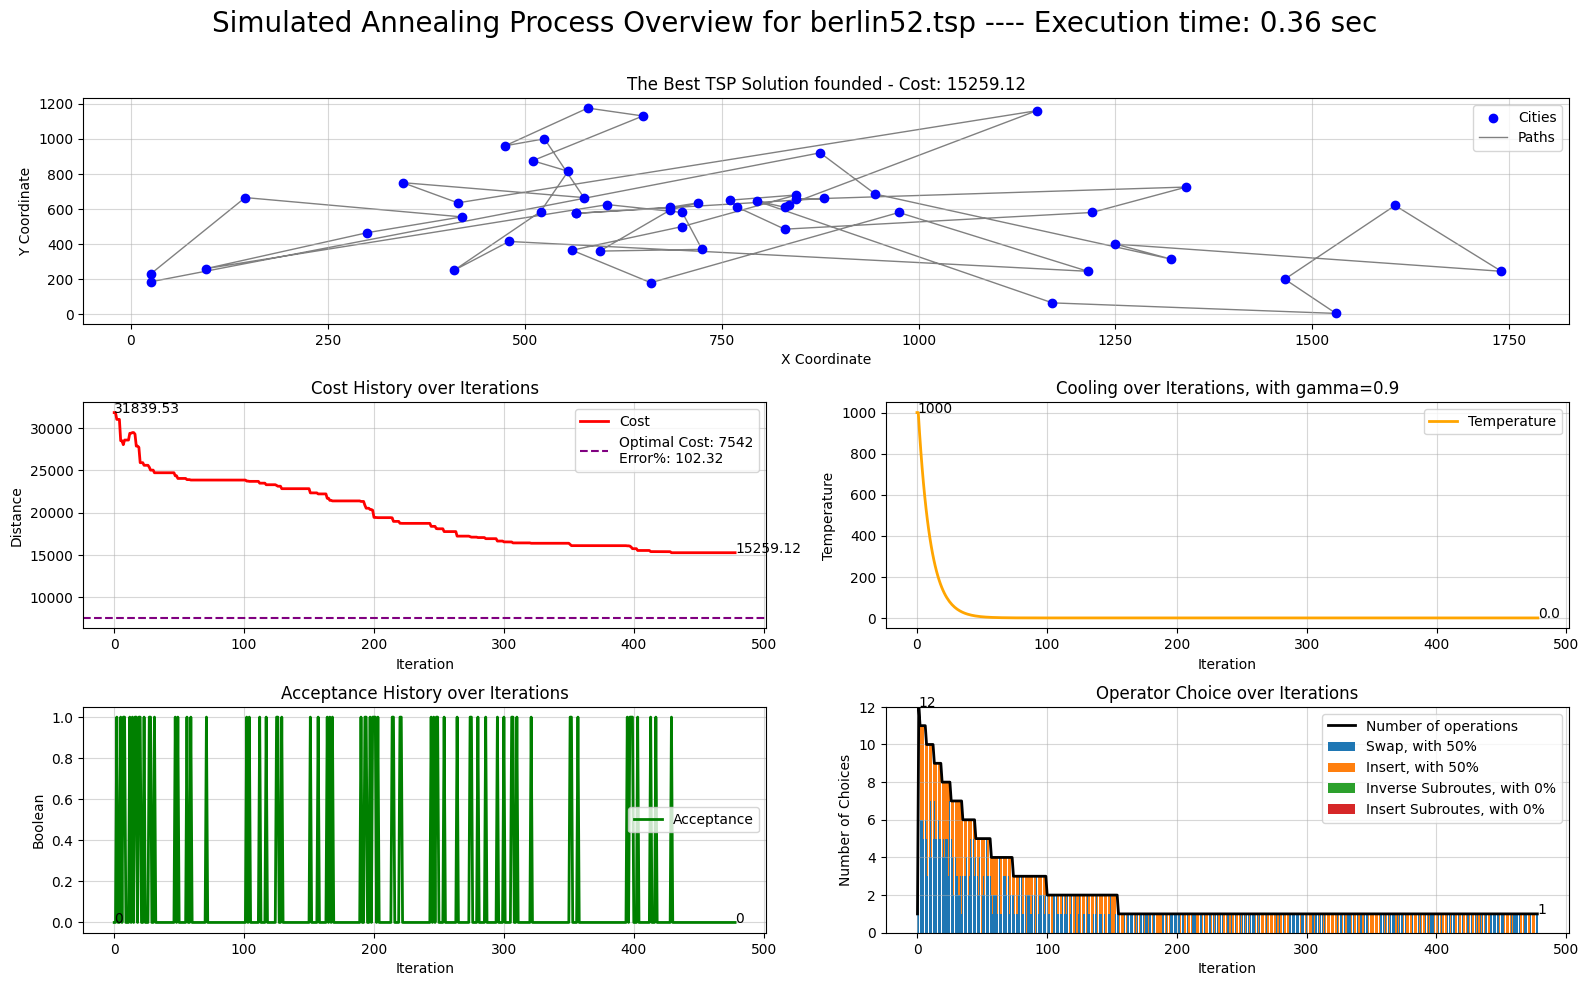

Best Solution: [1, 6, 5, 51, 12, 46, 37, 40, 15, 44, 20, 29, 25, 26, 23, 30, 22, 45, 19, 10, 9, 41, 8, 32, 3, 18, 33, 24, 48, 38, 47, 14, 13, 11, 52, 28, 27, 4, 43, 2, 7, 17, 31, 21, 42, 49, 34, 16, 50, 35, 39, 36, 1]
Best Cost: 15259.123417182582


In [ ]:
# Set the filename path for the Traveling Salesman Problem (TSP) data
filename = "berlin52.tsp"
tsp_data_filepath = "/content/drive/MyDrive/Colab Notebooks/optimisation/tsp_data/" + filename

# Define the parameters for the simulated annealing algorithm
params = {
    'initial temperature': 1000,
    'gamma': 0.9,
    'max solution selected': 50,
    'weights': [50, 50, 0, 0],
}


# Start measuring execution time
start_time = time.time()

# Execute the simulated annealing algorithm
history_solution, history_cost, history_temperature, history_acceptance, history_operator_choice = simulated_annealing(read_tsp_data(tsp_data_filepath),
                                                                                                                                                initial_temp=params['initial temperature'],
                                                                                                                                                gamma=params['gamma'],
                                                                                                                                                max_nbr_sol_selected=params['max solution selected'],
                                                                                                                                                weights=params['weights'])

# Calculate the total execution time
execution_time = time.time() - start_time

# Print the parameters and the execution time
for k, v in params.items():
    print(k+':', v)
print('>>>>> Execution time:', round(execution_time, 2))

# Display the results on a graph
suptitle = f'Simulated Annealing Process Overview for {filename} ---- Execution time: {round(execution_time, 2)} sec'
print_graph(suptitle, params, history_solution, history_cost, history_temperature, history_acceptance, history_operator_choice, optimal_cost=optimal_solutions[filename])

# Benchmark

In [ ]:
import os
from datetime import datetime
import csv

In [ ]:
def create_results_directory():
    # Get the current date and time
    current_date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    # Construct the directory name using the current date
    dir_name = f"results_tsp_{current_date}"
    # Build the full path for the directory
    path = os.path.join(os.getcwd(), dir_name)

    # Check if the directory exists
    if not os.path.exists(path):
        # Create the directory if it does not exist
        os.makedirs(path)

    return path

In [ ]:
def read_all_tsp_files(directory_path):
    tsp_files = [f for f in os.listdir(directory_path) if f.endswith('.tsp')]
    tsp_data = {}
    for file in tsp_files:
        filepath = os.path.join(directory_path, file)
        tsp_data[file] = read_tsp_data(filepath)
    return tsp_data

In [ ]:
def save_results_to_csv(results, output_filepath):
    # Check if the file already exists
    file_exists = os.path.isfile(output_filepath)

    with open(output_filepath, 'a', newline='') as csvfile:  # Use 'a' mode to append
        fieldnames = ['filename', 'parameters', 'best_solution', 'best_cost', 'optimal_cost', 'error_percentage', 'execution_time']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header only if the file does not exist
        if not file_exists:
            writer.writeheader()

        for filename, data in results.items():
            writer.writerow({
                'filename': filename,
                'parameters': data['parameters'],
                'best_solution': data['best_solution'],
                'best_cost': data['best_cost'],
                'optimal_cost': data['optimal_cost'],
                'error_percentage': data['error_percentage'],
                'execution_time': data['execution_time']
            })

In [ ]:
def benchmark_tsp_algorithms(tsp_data_dict, params, optimal_solutions, results_directory, save_graph=True):

    results = {}
    for filename, cities in tsp_data_dict.items():
        print('>>>>>', filename)

        # ############ # Execute the simulated annealing algorithm
        start_time = time.time()
        history_solution, history_cost, history_temperature, history_acceptance, history_operator_choice = simulated_annealing(cities,
                                                                                                                                initial_temp=params['initial temperature'],
                                                                                                                                gamma=params['gamma'],
                                                                                                                                max_nbr_sol_selected=params['max solution selected'],
                                                                                                                                weights=params['weights'])
        execution_time = time.time() - start_time

        # ############

        best_solution = [x[0] for x in history_solution[-1]]
        best_cost = history_cost[-1]

        optimal_cost = optimal_solutions.get(filename, None)
        error_percentage = round(abs((best_cost - optimal_cost) / optimal_cost)*100, 2) if optimal_cost else None

        results[filename] = {
            'parameters' : params,
            'best_solution': best_solution,
            'best_cost': best_cost,
            'optimal_cost': optimal_cost,
            'error_percentage': error_percentage,
            'execution_time': execution_time
        }

        # ############

        print(f'best_cost:', round(best_cost, 2))
        print('>>> execution_time :', round(execution_time/60, 2))
        print(f'----------------> error_percentage:', round(error_percentage, 2))


        # ############

        if save_graph:
            # Display the results on a graph
            graph_filename = filename.split('.')[0] + f"_with_parameters_temp_{params['initial temperature']}_max_{params['max solution selected']}_gamma_{''.join([str(l) for l in str(params['gamma']).split('.')])}_weights_{'_'.join([str(w) for w in params['weights']])}"
            graph_filepath = os.path.join(results_directory, graph_filename)
            optimal_cost = optimal_solutions[filename]
            suptitle = f'Simulated Annealing Process Overview for {filename} ---- Execution time: {round(execution_time, 2)} sec'
            print_graph(suptitle, params, history_solution, history_cost, history_temperature, history_acceptance, history_operator_choice, optimal_cost=optimal_solutions[filename], save_path=graph_filepath)

        # Save the results in csv
        output_filepath = os.path.join(results_directory, 'resultats.csv')
        save_results_to_csv(results, output_filepath)

    return results

In [ ]:
# Sets of parameters to test
param_sets = [
    {'initial temperature': 10000, 'gamma': 0.99, 'max solution selected': 1500, 'weights': [100, 0, 0, 0]},
    {'initial temperature': 10000, 'gamma': 0.99, 'max solution selected': 1500, 'weights': [50, 15, 30, 5]},
    {'initial temperature': 10000, 'gamma': 0.99, 'max solution selected': 1500, 'weights': [40, 30, 35, 5]},

    # Add other sets of parameters here
]

# Read TSP data
tsp_directory_path = "/content/drive/MyDrive/Colab Notebooks/optimisation/tsp_data1/"
tsp_data_dict = read_all_tsp_files(tsp_directory_path)
results_directory = create_results_directory()
print("Dossier de base créé :", results_directory)

# Iterate over each set of parameters and run the benchmark
all_results = {}
for param_set in param_sets:
    print('//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////')
    print('//////////////////// param_set:', param_set)
    results = benchmark_tsp_algorithms(tsp_data_dict, param_set, optimal_solutions, results_directory, save_graph=True)


Output hidden; open in https://colab.research.google.com to view.

Following multiple experiments to optimize performance and solution quality, we observed that the results are better, meaning they have the lowest error rate, when the weights, that is the balance between 'exchange operators & insertion operators,' are configured in the following way: [40, 30, 35, 5]